# Processamento de Imagens 01/2018 - SCC 5830
Professor: Dr. Moacir Antonelli Ponti

Aluna: Aline Regina Becher

NUSP: 10492388

## Algoritmo K-means para recuperação de imagens baseada em cor e textura
### Tema: Recuperação de imagens baseada em conteúdo

Encontrar representações em que o conteúdo é descrito por meio de características visuais é uma maneira de obter informações sobre a imagem.
O objetivo deste trabalho a busca visual de imagens baseada nas características de cor e textura. Tais características serão representadas através do histograma de cores e descritores de texturas de cada imagem.
 
Dada uma imagem de consulta, queremos encontrar imagens similares a ela de acordo com as características citadas anteriormente.

O conjunto de imagens usado para este fim é o dataset STL-10, disponível em https://cs.stanford.edu/~acoates/stl10/,  um dataset contendo 100.000 imagens de 10 classes distintas.

Para tanto, aqui usaremos apenas um subconjunto  com 8000 mil imagens.

O código fonte está divido nos seguintes passos, que serão detalhados em seguida:


**1) Carregar bibliotecas e funções**
        1.1) Carregar conjunto de imagens e imagem de consulta
        
**2) Pré processamento**

        2.1) Conversao do canal RGB para HSV;
        2.2) Equalização de histogramas no canal V;
        2.3) Conversão do canal RGB para HSV
        
 **3) Histograma de Cores/ descritores de textura**

        3.1) Histograma de cores em cada canal RGB/ descritores de textura em um único canal de cor.
        3.2) Vetor de características.
        
**4) Algoritmo K-means para classficação**
    
**5) Imagens de retorno**

## 1) Importando bibliotecas e Funções

Todas as funções necessárias estão implementadas em **functions_a.py**

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import random
from stl10_input import *
from functions_a import *
import cv2
import time

inicio = time.time()
b = 5
nbins = 2**b
t = np.random.randint(5000)
print(t)
list_all_images = read_all_images("test_X.bin")
image_search = read_all_images("train_X.bin")[t]
bshift = np.uint8(8 - b)
image_search_compare = image_search 

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
1356


# 2) Pré Processamento

### Conversão  RGB ==> HSV ==> RGB 

A equalização de histogramas considerando os canais RGB não é adequado pois resulta em erros no arranjo de cores. Para contornar esse problema, fazemos a conversão das imagens para o sistema de cores HSV (hue (matiz), saturation (saturação) e value (valor)). A equalização de histogramas é feita então apenas no canal V. Apesar de não alterar os componentes de matiz e saturação, este processo altera a percepção visual da imagem. Após esta etapa, convertemos as imagens para o sistema RGB novamente.

### Equalização de histogramas - Imagem de consulta

In [2]:
### equalização de histograma image_search ---------------------------------
image_search2 = hsv(image_search)
hist_color = hist(image_search2[:, :, 2], 256)
ha = hist_cumulative(hist_color, 256)
image_search2[:, :, 2] = equalization(image_search2[:, :, 2], ha)
image_search = cv2.cvtColor(image_search2, cv2.COLOR_HSV2BGR)

### Imagem de consulta

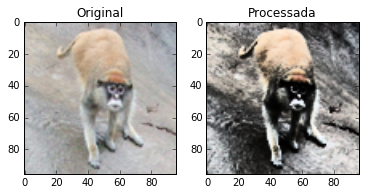

In [3]:
%matplotlib inline
plt.subplot(121)
plt.title('Original')
plt.imshow(image_search_compare)
plt.subplot(122)
plt.title('Processada')
plt.imshow(image_search)
plt.show()

## Equalização de histogramas - Imagens
Equalização de histogramas do conjunto de imagens no canal V, seguida da conversão para o sistema RGB.

In [4]:
### equalização de histograma  de imagens ----------------------------
Images = (np.zeros_like(list_all_images)).astype(np.uint8)
for i in range(8000):
    list_all_images[i, :, :, :] = hsv(list_all_images[i, :, :, :])
    hist_color = hist(list_all_images[i, :, :, 2], 256)
    ha = hist_cumulative(hist_color, 256)
    list_all_images[i, :, :, 2] = equalization(list_all_images[i, :, :, 2], ha)
    Images[i, :, :, :] = cv2.cvtColor(list_all_images[i, :, :, :], cv2.COLOR_HSV2BGR)

I = Images

## Vetor de Características - Histograma de cores
Aqui, extraímos as características das imagens baseada no histograma de cores. 
Computamos o histograma de cores em cada canal RGB, usando apenas os 32 bits mais significativos. Ao fim, para a imagem de consulta obtemos um vetor (dc_image_search) de tamanho 96. Para o conjunto de imagens, obtemos uma matriz D (8000, 96) em que cada linha representa o vetor de característica de uma imagem. 

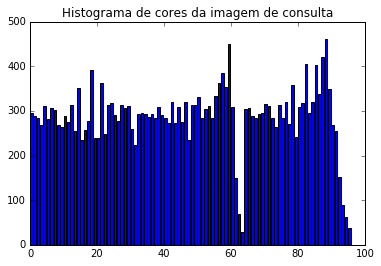

In [5]:
#  Vetor de características - imagem de consulta
image_search = image_search.astype(np.uint8)
image_search = (image_search >> bshift)
hist_color_0 = hist(image_search[:, :, 0],  nbins)
hist_color_1 = hist(image_search[:, :, 1], nbins)
hist_color_2 = hist(image_search[:, :, 2], nbins)
dc_image_search = np.concatenate((hist_color_0, hist_color_1))

dc_image_search = np.concatenate((dc_image_search, hist_color_2))

plt.bar(range(96), dc_image_search)
plt.title('Histograma de cores da imagem de consulta')

In [6]:
#---------------vetor de características Imagens------------------------

Images = Images.astype(np.uint8)
Images = (Images >> bshift)
D = np.zeros((8000, 3*nbins)).astype(float)
for i in range(8000):
    d = []
    for j in range(3):
        hist_c = hist(Images[i, :, :, j], nbins)
        d = np.concatenate((d, hist_c), nbins)
    D[i, :] = d
    
# A Matriz D contém os vetores de características de cada imagem do conjunto.

 # 4) Algoritmo K-means  
 
 O algoritmo K-means é um algoritmo de agrupamento que permite subdividir o conjunto em K subconjuntos de acordo com a similaridade entre os dados. O algoritmo inicia com a escolha de K elementos do conjunto, chamados de centróide e em seguida agrupa os elementos de conjunto aos centróides, de acordo com a similaridade entre eles. Aqui, escolhemos K vetores de características, de forma aleatória e fazemos o agrupamento das imagens de acordo com a similaridade com cada centróide. 
 
Pra o histograma de cores, calculamos a distância baseada na correlção entre os histogramas. Para os descritores de textura usamos a distância euclidiana.

### K-means para histograma de cores
Divide o conjunto em 600 subconjuntos.

Computa a distância entre a imagem de consulta e cada centróide. Retorna o índice do cetróide mais próximo

In [7]:
clusters, centroids, centers, ids = kmeans(D, 600, 1e-7, 1, 1)
dist_min = 1000000000
for i in range(centers):
     closest = hist_correl(centroids[i, :], dc_image_search)
     if closest < dist_min:
         dist_min = closest
         ind = i


/home/alinebecher/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alinebecher/.local/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


### Retorna as imagens relativas ao centróide mais próximo - histograma de cores

In [8]:
ids1 = np.where(clusters == ind)
ids1 = ids1[0]
print(ids1)

#ids1 = indíces das imagens mais proximas de acordo com o histograma de cores

[1052 1082 3209 4116 4458 6401]


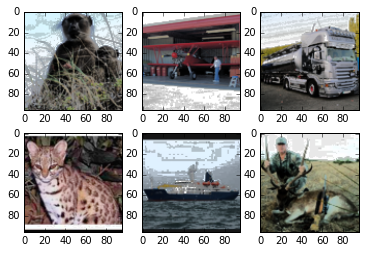

In [9]:
plt.subplot(231)
plt.imshow(I[1052])
plt.subplot(232)
plt.imshow(I[1082])
plt.subplot(233)
plt.imshow(I[3209])
plt.subplot(234)
plt.imshow(I[4116])
plt.subplot(235)
plt.imshow(I[4458])
plt.subplot(236)
plt.imshow(I[6401])


plt.savefig('1356_cores.png')
plt.show()

# Descritores de textura

Converte as imagens para um único canal de cor através do método Luminance.

31


<function matplotlib.pyplot.show(*args, **kw)>

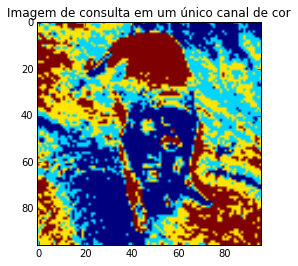

In [10]:
#-------------------Para textura ---------------------------------

image_search_ =  0.299*image_search[:, :, 0] + 0.587*image_search[:, :, 1] + 0.114*image_search[:, :, 2]
image_search_ = image_search_.astype(np.uint8)
image_search_ = (image_search_ >> bshift)
Images_ = 0.299*Images[:, :, :, 0] + 0.587*Images[:, :, :, 1] + 0.114*Images[:, :, :, 2]
Images_ = Images_.astype(np.uint8)
print(np.max(Images))
plt.title('Imagem de consulta em um único canal de cor')
plt.imshow(image_search_)
plt.show

# Vetor de características - Textura

Computa o vetor de característica de (tamanho 5) das imagens, em que cada entrada do vetor representa energia, entropia, contraste, correlação e homogeneidade, respectivamente. 

In [11]:
#---------------------descritores de textura para image_search---------

G_is = texture_descriptors(image_search_, nbins)
u_i, u_j = medias(G_is, nbins)
sigma_i, sigma_j = desvios(G_is, u_i, u_j, nbins)
d_is = haralick_descriptors(G_is, u_i, u_j, sigma_i, sigma_j, nbins)

In [12]:
# Descritores de textura para conjunto de imagens-----------
d = np.zeros((8000, 5)).astype(float)
for i in range(8000):
    G = texture_descriptors(Images_[i, :, :], nbins)
    u_i, u_j = medias(G, nbins)
    sigma_i, sigma_j = desvios(G, u_i, u_j, nbins)
    d[i, :] = haralick_descriptors(G, u_i, u_j, sigma_i, sigma_j, nbins)

### Algoritmo K means para textura

In [13]:
clusters, centroids, centers, ids = kmeans(d, 600, 1e-7, 2, ids)
dist_min = 1000000000
for i in range(centers):
     closest = euclidean(centroids[i, :],d_is)
     if closest < dist_min:
         dist_min = closest
         ind = i

### Retorna as imagens relativas o centróide mais próximo - textura

In [14]:
ids2 = np.where(clusters == ind)
ids2 = ids2[0]
print(ids2)
fim = time.time()


[ 154  225  806  985 1857 1940 2023 2027 2217 2461 2603 2867 3210 3286
 3487 3676 4394 4590 4910 5255 5438 5624 6040 6065 6494 6767 6776 7402
 7626]


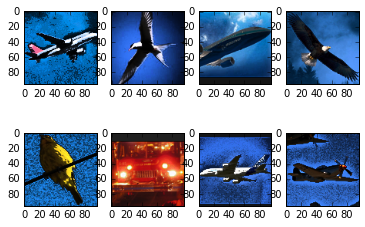

In [15]:
plt.subplot(241)
plt.imshow(I[154])
plt.subplot(242)
plt.imshow(I[225])
plt.subplot(243)
plt.imshow(I[1857])
plt.subplot(244)
plt.imshow(I[2023])
plt.subplot(245)
plt.imshow(I[2461])
plt.subplot(246)
plt.imshow(I[3286])
plt.subplot(247)
plt.imshow(I[3487])
plt.subplot(248)
plt.imshow(I[4394])

plt.savefig('1356_t1.png')
plt.show()

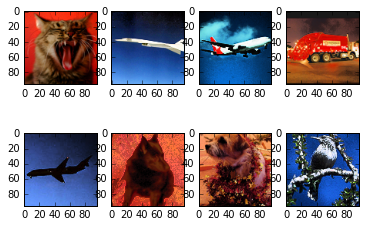

In [16]:
plt.subplot(241)
plt.imshow(I[4590])
plt.subplot(242)
plt.imshow(I[5255])
plt.subplot(243)
plt.imshow(I[5624])
plt.subplot(244)
plt.imshow(I[6040])
plt.subplot(245)
plt.imshow(I[6065])
plt.subplot(246)
plt.imshow(I[6767])
plt.subplot(247)
plt.imshow(I[7402])
plt.subplot(248)
plt.imshow(I[7626])

plt.savefig('1356_t2.png')
plt.show()